In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, addcyclic
from datetime import datetime
# Spatial subsetting of netcdf files
import regionmask
import glob
import rioxarray
from shapely.geometry import mapping
import pickle
import copy

import pytesmo.timedate.dekad as dekad
import pytesmo.timedate

In [2]:
root_path = '/home/tiro/Data/atkins/activities/activity_2.1b/data/'

file_path_obs = root_path+'*/*/*/*/*/*/sadc/'

mask_file = glob.glob(file_path_obs+'era5_land_sea_mask_SA_no_lakes.nc')
mask = xr.open_dataset(mask_file[0]).pr
files_obs = glob.glob(file_path_obs+'*era5.nc')


### RAN

files_obs = glob.glob(file_path_obs+'*era5.nc')

files_obs = files_obs[4:]

for ref_file in files_obs:
    var = 'pr'
    ifile = ref_file
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    #print(dataset)
    file_xr = xr.open_dataset(ref_file)
    file_xr = file_xr.chunk('auto')
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]
    if dataset == 'mswep-v280':
        var = 'precipitation'
    clim_var_ref = file_xr[var]
    
    clim_var_ref =clim_var_ref.sel(time = slice('1983','2021'))

    clim_var_ref = clim_var_ref*mask

    years = pd.to_datetime(clim_var_ref.time.resample(time = '1Y').min().to_dataframe().index).year
    year_1 = clim_var_ref.time.resample(time = '1Y').min().to_dataframe().index[0]
    year = years[0]

    yr = str(str(year)+'-07-01')
    yr_2 = str(str(np.intc(year)+1)+'-06-30')

    ts_yr = clim_var_ref.sel(time = slice(yr, yr_2))  
    #print(ts_yr)
    m2 = ts_yr.rolling(time = 3).sum() >= 20

    m3 = ts_yr.shift(time = 3).rolling(time = 7).sum().shift(time = -13) > 0


    day = ts_yr.where(m2==True).where(m3==True)


    results = []
    results_1 = pd.DataFrame([])
    for t in np.arange(len(day.time)):

        doy = pd.to_datetime(day.time)[t].dayofyear
        ### Get the dekad for the dayofyear
        dekads_val = dekad.get_dekad_period([pd.to_datetime(day.time)[t]])
        onset_dekad = dekads_val[0]
        ### Identify gridpoits that have no precipitation and replace with -1
        day_2 = day[t, :, :].where(day[t, :, :] > 0, other= -1)

        ### Identify all gridpoints with precipitation and replace them with the dekad value
        day_2 = day_2.where(day_2 < 0, other= onset_dekad)
        ### All negative numbers are replaced win nan
        day_3 = day_2.where(day_2 > 0, other= np.nan)

        if onset_dekad < 18:
            #print(pd.to_datetime(day.time)[t], onset_dekad)
            day_2 = day[t, :, :].where(day[t, :, :] > 0, other= -1)
            day_2 = day_2.where(day_2 < 0, other= onset_dekad+36)
            day_3 = day_2.where(day_2 > 0, other= np.nan)

        results.append(np.array(day_3).flatten())
    
    output = np.copy(results).reshape(len(day.time), len(day.latitude), len(day.longitude))
    onset_dates = xr.DataArray(output, dims = ('time', 'latitude', 'longitude' ), coords= {'time':np.arange(len(day.time)), 'longitude':day.longitude, 'latitude':day.latitude})    
    onset_dates = onset_dates.rename('onset_dekads')
    final_onset = onset_dates.min('time')


    for i in np.arange(1,len(years),1):  
        year = years[i]
        yr = str(str(year)+'-07-01')
        yr_2 = str(str(np.intc(year)+1)+'-06-30')

        ts_yr = clim_var_ref.sel(time = slice(yr, yr_2))  
        #print(ts_yr)
        m2 = ts_yr.rolling(time = 3).sum() >= 20
        m2_1 = ts_yr.rolling(time = 3).sum()

        m3 = ts_yr.shift(time = 3).rolling(time = 10).sum().shift(time = -9) - ts_yr.rolling(time = 3).sum().shift(time = -2) > 0
        m3_1 = ts_yr.shift(time = 3).rolling(time = 10).sum().shift(time = -9) - ts_yr.rolling(time = 3).sum().shift(time = -2)

        m3 = ts_yr.shift(time = 3).rolling(time = 10).sum().shift(time = -13) > 0
        m3_1 = ts_yr.shift(time = 3).rolling(time = 10).sum().shift(time = -13)
        m3_2 = ts_yr.rolling(time = 3).sum().shift(time = -3)
        m3_3 = ts_yr.shift(time = 3).rolling(time = 10).sum().shift(time = -13) - ts_yr.rolling(time = 3).sum()

        day = ts_yr.where(m2==True).where(m3==True)


        results = []
        
        for t in np.arange(len(day.time)):

            doy = pd.to_datetime(day.time)[t].dayofyear
            ### Get the dekad for the dayofyear
            dekads_val = dekad.get_dekad_period([pd.to_datetime(day.time)[t]])
            onset_dekad = dekads_val[0]
            ### Identify gridpoits that have no precipitation and replace with -1
            day_2 = day[t, :, :].where(day[t, :, :] > 0, other= -1)

            ### Identify all gridpoints with precipitation and replace them with the dekad value
            day_2 = day_2.where(day_2 < 0, other= onset_dekad)
            ### All negative numbers are replaced win nan
            day_3 = day_2.where(day_2 > 0, other= np.nan)

            if onset_dekad < 18:
                #print(pd.to_datetime(day.time)[t], onset_dekad)
                day_2 = day[t, :, :].where(day[t, :, :] > 0, other= -1)
                day_2 = day_2.where(day_2 < 0, other= onset_dekad+36)
                day_3 = day_2.where(day_2 > 0, other= np.nan)
 
            results.append(np.array(day_3).flatten())
        
        output = np.copy(results).reshape(len(day.time), len(day.latitude), len(day.longitude))
        onset_dates = xr.DataArray(output, dims = ('time', 'latitude', 'longitude' ), coords= {'time':np.arange(len(day.time)), 'longitude':day.longitude, 'latitude':day.latitude})    
        onset_dates = onset_dates.rename('onset_dekads')
        onset_dates = onset_dates.min('time')
        final_onset = xr.concat([final_onset, onset_dates], dim='time')
    times = pd.DatetimeIndex(clim_var_ref.time.resample(time = '1Y').min().values,closed='left')
    #final_onset.assign_coords({"time": times})
    final_onset = final_onset.assign_coords({("time"): times})
        #print(str(onset_dates[:, :].sel(longitude = lon, latitude = lat).values))
    final_onset.to_netcdf('../data/onset_dates/onset_dekads_'+institute+'_'+dataset+'.nc')



In [4]:
!ls -lrth ../data/onset_dates/onset_dekads*

-rw-rw-r-- 1 tiro tiro 5.5M Apr 28 14:16 ../data/onset_dates/onset_dekads_CPC_ARC2.nc
-rw-rw-r-- 1 tiro tiro 5.4M Apr 28 14:23 ../data/onset_dates/onset_dekads_TAMSAT_RFE-filled-V3.1.nc
-rw-rw-r-- 1 tiro tiro 5.5M Apr 28 14:57 ../data/onset_dates/onset_dekads_GloH2O_mswep-v280.nc
-rw-rw-r-- 1 tiro tiro 5.4M Apr 28 15:46 ../data/onset_dates/onset_dekads_GPCC_full-data-first-guess.nc
-rw-rw-r-- 1 tiro tiro 3.1M Apr 28 15:48 ../data/onset_dates/onset_dekads_GPM_IMERG.nc
-rw-rw-r-- 1 tiro tiro 3.3M Apr 28 15:50 ../data/onset_dates/onset_dekads_NOAA-CPC_CMORPH-CDR.nc
-rw-rw-r-- 1 tiro tiro 5.4M Apr 28 15:54 ../data/onset_dates/onset_dekads_ECMWF_ERA5.nc
-rw-rw-r-- 1 tiro tiro 5.4M Oct  5 12:58 ../data/onset_dates/onset_dekads_CHC_CHIRPS-2.0-0p25.nc


RFE-filled-V3
CHIRPS-2
mswep-v280
full-data-first-guess
IMERG
CMORPH-CDR
ERA5


/tmp/ipykernel_8538/4093330701.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


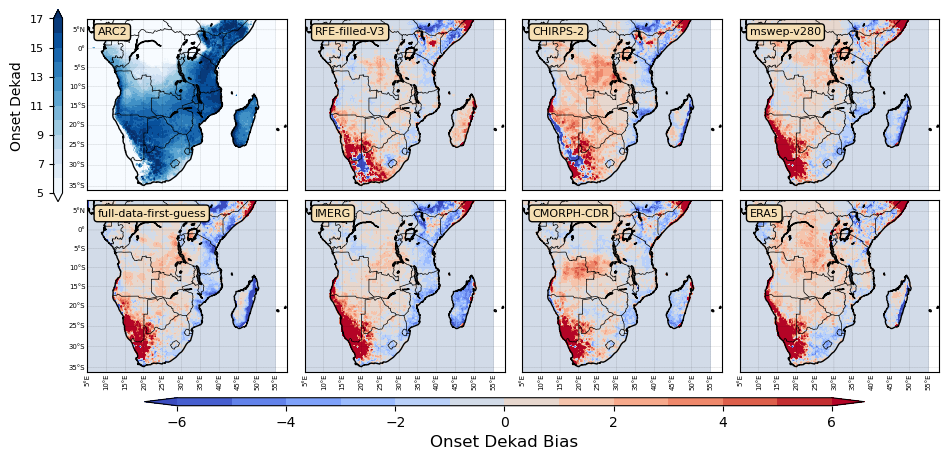

In [5]:
def choose_var_rsme(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_biaas']
        'onset_dekad'                                                        :  [ 5, 18, 1, -6, 7, 1],
    }[var]
    
    
year1 = str(2001)
year2 = str(2020)



#for index in indices:
#    print(index)
var = 'onset_dekad'
variables = ['onset_dekad']
files_obs_ann = glob.glob('../data/onset_dates/onset_dekads*.nc')
#files_obs_ann = 

observed_data = files_obs_ann
observed_data = observed_data[1:len(observed_data)]

#variables = list(file_xr.keys())
datasets_all = ['CPC_ARC2', 'TAMSAT_RFE-filled-V3.1', 'CHC_CHIRPS-2.0-0p25', 'GloH2O_mswep-v280', 
                'GPCC_full-data-first-guess', 'GPM_IMERG', 'NOAA-CPC_CMORPH-CDR', 'ECMWF_ERA5']

for var in variables:
    fig = plt.figure(figsize=(9,4))
    i=0
    ax = fig.add_subplot(2, 4, i+1)
    ref_file = glob.glob('../data/onset_dates/onset_dekads_'+datasets_all[i]+'.nc')
    ifile = ref_file[0]
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_base=filename.split(".")[0]
    filename_split=filename_base.split("_")
    institute=filename_split[2]  
    dataset=filename_split[3]
    file_xr = xr.open_dataset(ifile)
    file_xr = file_xr.chunk('auto')
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]

    levs = np.arange(choose_var_rsme(var)[0],choose_var_rsme(var)[1], choose_var_rsme(var)[2])
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    clim_var_ref = file_xr.sel(time=slice(year1,year2))
    
    clim_var_ref = clim_var_ref*mask
    clim_var_ref_1 =clim_var_ref.resample(time='1Y').sum().mean('time')
    clim_var_ref_1 = clim_var_ref_1 - 18

    pl1 = map.contourf(x2d,y2d,clim_var_ref_1.onset_dekads[:,:],levs,extend='both',cmap='Blues')
    min_val = clim_var_ref.min().values
    max_val = clim_var_ref.max().values

    map.drawcoastlines()
    map.drawcountries()
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=[1,0,0,0], fontsize=5,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
            labels=[0,0,0,0], fontsize=0,linewidth=0.1)

    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
    clim_var_ref_1  = clim_var_ref_1 + 18
    
    for i in np.arange(len(observed_data)): 
        i=i+1
        ifile = glob.glob('../data/onset_dates/onset_dekads_'+datasets_all[i]+'.nc')
        ax = fig.add_subplot(2, 4, i+1)
        file_split=ifile[0].split("/")
        filename=file_split[-1]
        filename_base=filename.split(".")[0]
        filename_split=filename_base.split("_")
        institute=filename_split[2]  
        dataset=filename_split[3]
        print(dataset)
        file_xr = xr.open_dataset(ifile[0])
        file_xr = file_xr.chunk('auto')
        lons = file_xr.variables['longitude'][:]
        lats = file_xr.variables['latitude'][:]

        levs_1 = np.arange(choose_var_rsme(var)[3],choose_var_rsme(var)[4], choose_var_rsme(var)[5])
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
        clim_var = file_xr.sel(time=slice(year1,year2))
        clim_var = clim_var*mask
        #clim_var = clim_var.resample(time='1M').sum('time')
        #clim_var = clim_var.mean('time')
        clim_var =clim_var.resample(time='1Y').sum().mean('time')
        
        clim_var_rsme = clim_var - clim_var_ref_1

        pl2 = map.contourf(x2d,y2d,clim_var_rsme.onset_dekads[:,:],levs_1,extend='both',cmap='coolwarm')
        map.drawcoastlines()
        map.drawcountries()

        if i in [1,2,3]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
        if i in [4]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[1,0,0,0], fontsize=5,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)
        if i in [5,6,7,8]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)

        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)

    cax2 = fig.add_axes([-0.001, 0.5, 0.01, 0.48])    
    bar2 = fig.colorbar(pl1, cax=cax2, orientation='vertical', ticklocation = 'left', extend = 'max')
    bar2.set_label('Onset Dekad',size=10)
    bar2.ax.tick_params(labelsize=8) 
    #bar2.ax.tick_params(labelsize=8,labelleft='True', labelright = 'False', left = 'True', right = 'False')

    cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal', extend = 'min')
    bar.set_label('Onset Dekad Bias',size=12)
    plt.tight_layout()
    #fig.suptitle(var, fontsize=16, y=1.05)
    #plt.savefig('Images/prcptot/'+var+'_onset_dekads.png', bbox_inches='tight',dpi=300)



In [ ]:
dataset